(moist_adiabats)=
# Moist adiabats and the LCL

This notebook shows how to find the lifting condensation level of a sounding, and identify $\theta_{es}$ for the moist adiabat going through cloud base.

In [1]:
import numpy as np
import pandas as pd
from pprint import pformat

from a500.thermo.constants import constants as c
from a500.thermo.thermlib import convertSkewToTemp, convertTempToSkew
from a500.skewT.fullskew import makeSkewWet,find_corners,make_default_labels

In [2]:
from a500.soundings.wyominglib import write_soundings, read_soundings
from matplotlib import pyplot as plt

## Grab a Little Rock sounding

Set get_data = True to fetch the Wyoming sounding data from the website and store it.

In [3]:
get_data = True
values=dict(region='naconf',year='2012',month='7',start='0100',stop='3000',station='72340')
if get_data:
    write_soundings(values, 'littlerock')
soundings= read_soundings('littlerock')

687501
header is:  72340 LZK Little Rock Observations at 00Z 01 Jul 2012
here is the day:  120701
here is the day:  120701
here is the day:  120702
here is the day:  120702
here is the day:  120703
here is the day:  120703
here is the day:  120704
here is the day:  120704
here is the day:  120705
here is the day:  120705
here is the day:  120706
here is the day:  120706
here is the day:  120707
here is the day:  120707
here is the day:  120708
here is the day:  120708
here is the day:  120709
here is the day:  120709
here is the day:  120710
here is the day:  120710
here is the day:  120711
here is the day:  120711
here is the day:  120712
here is the day:  120712
here is the day:  120713
here is the day:  120713
here is the day:  120714
here is the day:  120714
here is the day:  120715
here is the day:  120715
here is the day:  120716
here is the day:  120716
here is the day:  120717
here is the day:  120717
here is the day:  120718
here is the day:  120718
here is the day:  120719
he

In [4]:
soundings['sounding_dict'].keys()

dict_keys([(2012, 7, 1, 0), (2012, 7, 1, 12), (2012, 7, 2, 0), (2012, 7, 2, 12), (2012, 7, 3, 0), (2012, 7, 3, 12), (2012, 7, 4, 0), (2012, 7, 4, 12), (2012, 7, 5, 0), (2012, 7, 5, 12), (2012, 7, 6, 0), (2012, 7, 6, 12), (2012, 7, 7, 0), (2012, 7, 7, 12), (2012, 7, 8, 0), (2012, 7, 8, 12), (2012, 7, 9, 0), (2012, 7, 9, 12), (2012, 7, 10, 0), (2012, 7, 10, 12), (2012, 7, 11, 0), (2012, 7, 11, 12), (2012, 7, 12, 0), (2012, 7, 12, 12), (2012, 7, 13, 0), (2012, 7, 13, 12), (2012, 7, 14, 0), (2012, 7, 14, 12), (2012, 7, 15, 0), (2012, 7, 15, 12), (2012, 7, 16, 0), (2012, 7, 16, 12), (2012, 7, 17, 0), (2012, 7, 17, 12), (2012, 7, 18, 0), (2012, 7, 18, 12), (2012, 7, 19, 0), (2012, 7, 19, 12), (2012, 7, 20, 0), (2012, 7, 20, 12), (2012, 7, 21, 0), (2012, 7, 21, 12), (2012, 7, 22, 0), (2012, 7, 22, 12), (2012, 7, 23, 0), (2012, 7, 23, 12), (2012, 7, 24, 0), (2012, 7, 24, 12), (2012, 7, 25, 0), (2012, 7, 25, 12), (2012, 7, 26, 0), (2012, 7, 26, 12), (2012, 7, 27, 0), (2012, 7, 27, 12), (2012, 7

## Select one sounding -- July 17, 2012 at 0 UCT

In [5]:
the_time=(2012,7,17,0)
sounding=soundings['sounding_dict'][the_time]
sounding.columns

Index(['Unnamed: 0', 'pres', 'hght', 'temp', 'dwpt', 'relh', 'mixr', 'drct',
       'sknt', 'thta', 'thte', 'thtv'],
      dtype='object')

## Save the metadata for plotting

In [6]:
title_string=soundings['attributes']['header']
index=title_string.find(' Observations at')
location=title_string[:index]
print(f'location: {location}')

units=soundings['attributes']['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns[1:]):
    units_dict[var]=units[count]
#
# use the pretty printer to print the dictionary
#
print(f'units: {pformat(units_dict)}')

location: 72340 LZK Little Rock
units: {'drct': 'deg',
 'dwpt': 'C',
 'hght': 'm',
 'mixr': 'g/kg',
 'pres': 'hPa',
 'relh': '%',
 'sknt': 'knot',
 'temp': 'C',
 'thta': 'K',
 'thte': 'K',
 'thtv': 'K'}


## Convert temperature and dewpoint to skew coords

In [7]:
skew=35.
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))

## Plot the sounding, making the sounding lines thicker

In [8]:
def label_fun():
    """
    override the default rs labels with a tighter mesh
    """
    from numpy import arange
    #
    # get the default labels
    #
    tempLabels,rsLabels, thetaLabels, thetaeLabels = make_default_labels()
    #
    # change the temperature and rs grids to get a finer mesh
    #
    tempLabels = range(-40, 50, 2)
    rsLabels = [0.1, 0.25, 0.5, 1, 2, 3] + list(np.arange(4, 28, 2)) 
    return tempLabels,rsLabels, thetaLabels, thetaeLabels

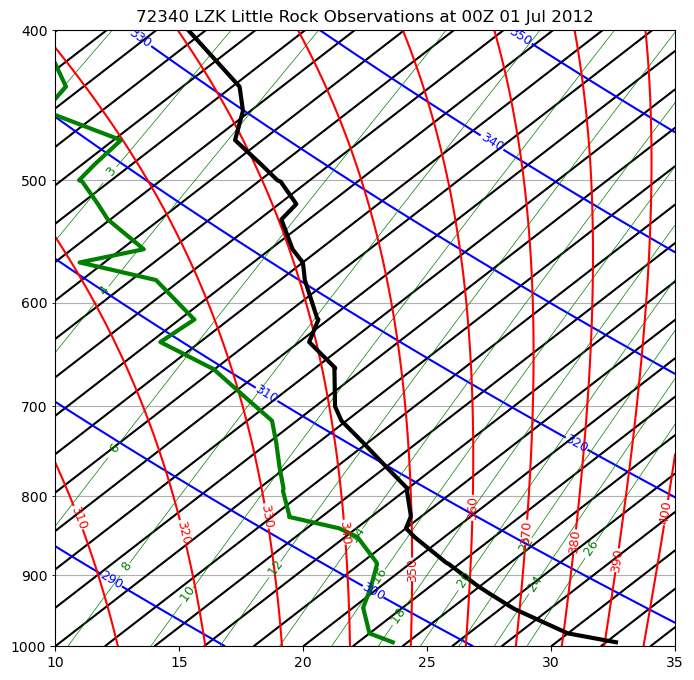

In [9]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners = [10, 35]
ax, skew = makeSkewWet(ax, corners=corners, skew=skew,label_fun=label_fun)
#ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
out=ax.set(title=title_string)
xcorners=find_corners(corners,skew=skew)
ax.set(xlim=xcorners,ylim=[1000,400]);
l1,=ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
l2,=ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in [l1,l2]];

## Find the $\theta_{es}$ of the  LCL

The thermo.thermlib docs are [here](https://phaustin.github.io/a405_lib/full_listing.html#module-a405.thermo.thermlib)

In [10]:
from a500.thermo.thermlib import (find_Tmoist,find_thetaep,find_rsat,
                                 find_Tv,find_lcl,find_thetaes,find_thetaet)
#
# find thetae of the surface air, which is at index 0
#
sfc_press,sfc_temp,sfc_td =[sounding[key][0] for key in ['pres','temp','dwpt']]
#
# convert to Kelvin
#
sfc_press,sfc_temp,sfc_td = sfc_press*100.,sfc_temp+c.Tc,sfc_td+c.Tc

### What is the LCL of this air?

In [11]:
Tlcl, plcl=find_lcl(sfc_td, sfc_temp,sfc_press)

In [12]:
print(f'found Tlcl={Tlcl:0.1f} K, plcl={plcl:0.1f} Pa')

found Tlcl=294.4 K, plcl=87210.4 Pa


/Users/phil/mini310/envs/a500/lib/python3.11/site-packages/a500/thermo/thermlib.py:469: RuntimeWarning: invalid value encountered in log
  s = cp * np.log(T) - c.Rd * np.log(pd) + lv * rv / T - vapor_term


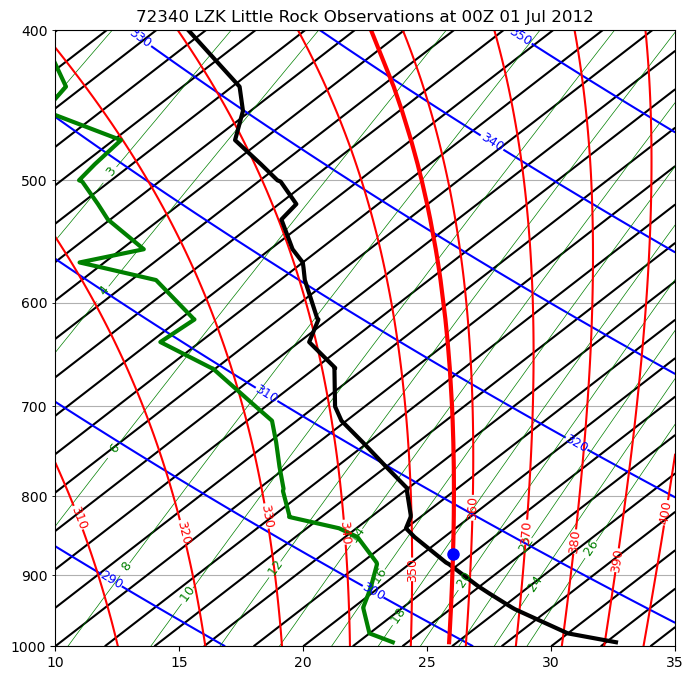

In [13]:
#  convert to mks and find surface rv and thetae
#
sfc_rvap = find_rsat(sfc_td,sfc_press)
lcl_rvap = find_rsat(Tlcl,plcl)
sfc_thetae=find_thetaes(Tlcl,plcl)
press=sounding['pres'].values*100.
#
# find the index for 70 hPa pressure -- searchsorted requires
# the pressure array to be increasing, so flip it for the search,
# then flip the index.  Above 70 hPa thetae goes bananas, so
# so trim so we only have good values
#
toplim=len(press) - np.searchsorted(press[::-1],.7e4)
clipped_press=press[:toplim]
#
# find temps, rv and rl along that adiabat
#
adia_temps= np.array([find_Tmoist(sfc_thetae,the_press) 
                      for the_press in clipped_press])
adia_rvaps = find_rsat(adia_temps,clipped_press)
adia_rls = sfc_rvap - adia_rvaps
env_temps = (sounding['temp'].values + c.Tc)[:toplim]
env_Td = (sounding['dwpt'].values + c.Tc)[:toplim]
height = sounding['hght'].values[:toplim]
pairs = zip(env_Td,clipped_press)
env_rvaps= np.array([find_rsat(td,the_press) for td,the_press in pairs])
env_Tv = find_Tv(env_temps,env_rvaps)
adia_Tv = find_Tv(adia_temps,adia_rvaps,adia_rls)
xcoord_thetae=[]
press_hPa = clipped_press*1.e-2
#
# convert the adiabatic thetae sounding to skewT coords
#
for a_temp,a_press in zip(adia_temps - c.Tc,press_hPa):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_thetae.append(out)
ax.plot(xcoord_thetae,press_hPa,color='r',label='thetae',linewidth=3.)
xlcl=convertTempToSkew(Tlcl - c.Tc,plcl*0.01,skew)
ax.plot(xlcl,plcl*0.01,'bo',markersize=8)
display(fig)